In [26]:
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from safetensors import safe_open
from transformers import AutoTokenizer

from sae.data import chunk_and_tokenize

In [27]:
tensors = {}
path = "../checkpoints/cross-layer-test/fvu-scaling-cross-test_20240814_051215/h.5_h.6_h.7_h.8"
with safe_open(f"{path}/sae.safetensors", framework="pt", device=0) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

In [28]:
tensors.keys()

dict_keys(['W_dec', 'b_dec', 'encoder.bias', 'encoder.weight'])

In [29]:
# (latent, d_in)
W_dec = tensors["W_dec"]
# (latent, d_in)
W_enc = tensors["encoder.weight"]

In [30]:
W_dec.shape, W_dec.shape

(torch.Size([98304, 3072]), torch.Size([98304, 3072]))

In [31]:
d_embd = 768
decoder_chunks = W_dec.split(d_embd, dim=1)
encoder_chunks = W_enc.split(d_embd, dim=1)

In [32]:
[c.shape for c in decoder_chunks]

[torch.Size([98304, 768]),
 torch.Size([98304, 768]),
 torch.Size([98304, 768]),
 torch.Size([98304, 768])]

In [33]:
decoder_layer_norms = [x.norm(dim=-1) for x in decoder_chunks]
encoder_layer_norms = [x.norm(dim=-1) for x in encoder_chunks]

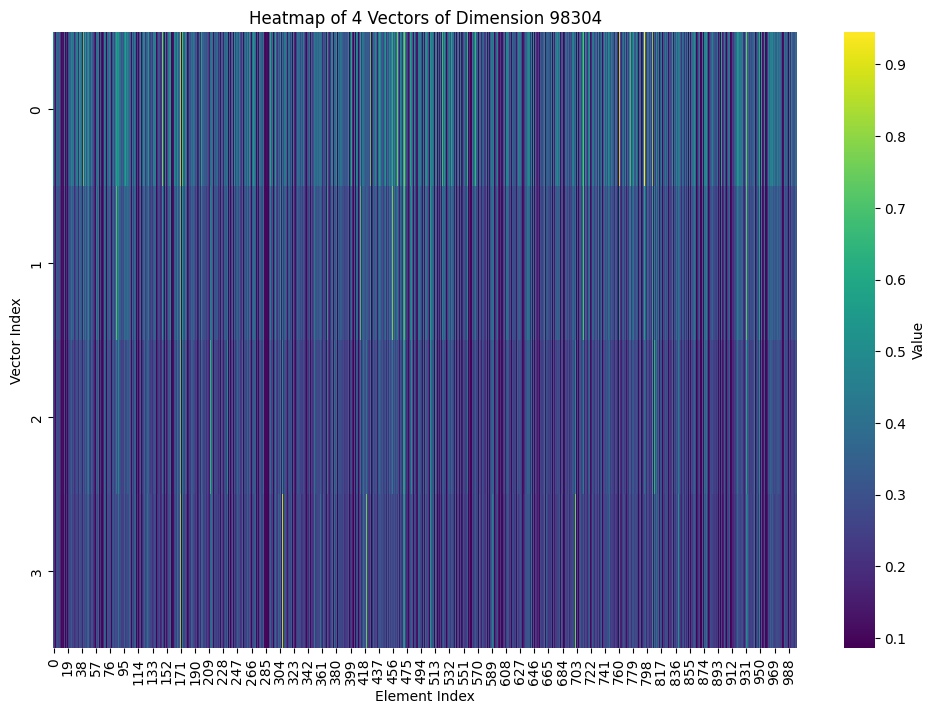

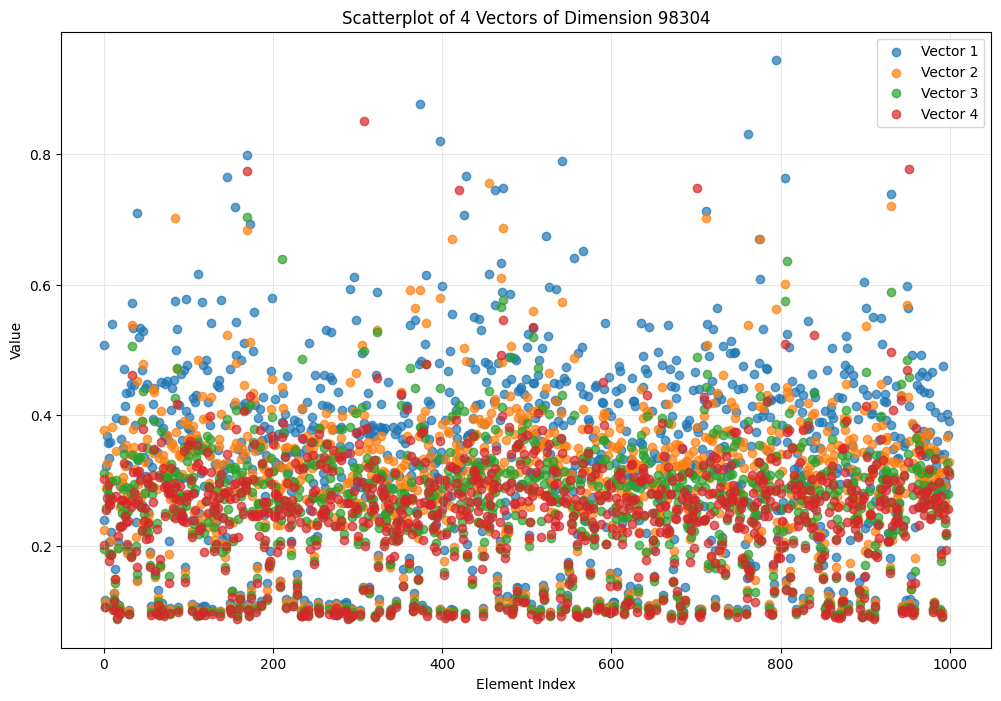

In [45]:
def create_scatterplot(vectors, x1, x2):
    L, N = vectors.shape
    plt.figure(figsize=(12, 8))

    for i in range(L):
        x = torch.arange(x1, x2)
        y = vectors[i, x1:x2].cpu().numpy()
        plt.scatter(x, y, label=f"Vector {i+1}", alpha=0.7)

    plt.xlabel("Element Index")
    plt.ylabel("Value")
    plt.title(f"Scatterplot of {L} Vectors of Dimension {N}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def create_heatmap(vectors, x1, x2):
    L, N = vectors.shape
    plt.figure(figsize=(12, 8))

    sns.heatmap(
        vectors.cpu().numpy()[:, x1:x2], cmap="viridis", cbar_kws={"label": "Value"}
    )

    plt.xlabel("Element Index")
    plt.ylabel("Vector Index")
    plt.title(f"Heatmap of {L} Vectors of Dimension {N}")
    plt.show()


norms = torch.stack(encoder_layer_norms)
# norms = norms / norms.norm(p=2, dim=0, keepdim=True)
x1, x2 = 0, 1000

create_heatmap(norms, x1, x2)
create_scatterplot(norms, x1, x2)

In [49]:
norms.T.norm(dim=1)

tensor([0.7674, 0.4311, 0.2214,  ..., 0.4581, 0.5976, 0.4426], device='cuda:0')